### Kernelized Supervised Laplacian Eigenmap of Multi-Label Data
This python code is an implementation of Kernelized Supervised Laplacian Eigenmap for Visualization and Classification of Multi-Label Data published in Pattern Recognition journal. For citation, please use below:

Mariko Tai, Mineichi Kudo, Akira Tanaka, Hideyuki Imai, and Keigo Kimura,
"Kernelized Supervised Laplacian Eigenmap for Visualization and Classification of Multi-Label Data." Pattern Recognition, available online at
https://doi.org/10.1016/j.patcog.2021.108399

First, let's prepare necessary libralies. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import offsetbox
import numpy as np
import sys
import math
import scipy.linalg
from numpy import linalg as LA
from sklearn.metrics import pairwise

from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components

from sklearn import datasets
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.base import BaseEstimator
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding

from scipy.sparse import csr_matrix, isspmatrix
from matplotlib.colors import LinearSegmentedColormap    #
import random
from sklearn.metrics import classification_report, accuracy_score



The following is main body.

In [2]:
class KSLE_ML():
    def __init__(self, n_components=2, affinity="nearest_neighbors",
                 random_state=None, eigen_solver=None,
                 n_neighbors=None, kernel=None, kopt1=None, n_jobs=1, la=None):
        self.n_components = n_components
        self.affinity = affinity
        self.random_state = random_state
        self.eigen_solver = eigen_solver
        self.n_neighbors = n_neighbors
        #print(n_neighbors)
        self.n_jobs = n_jobs
        self.la = la
 
        # Kernel selection with option
        self.kernel = kernel
        self.kopt1 = kopt1

    @property
    def _pairwise(self):
        return self.affinity == "precomputed"

    def _change_kernel(self, kernel, kopt1=None, setonly =False):
        self.kernel = kernel
        self.kopt1 = kopt1
        ans = True
        if setonly == False:
            G = self._calc_kernel(self.X, self.X)
            self.G = G

            # Solve linear equation GC = Z instead of C = G^{-1}Z 
            rank = np.linalg.matrix_rank(G)
            print('Rank of G is '+str(rank))

            try:
                self.C = np.linalg.solve(G, self.Z)
            except np.linalg.LinAlgError as e:
                if 'Singular matrix' in str(e):
                        exit()
            ans = (rank==self.X.shape[0])
            print('(change)self.C.shape = '+str(self.C.shape)+' rank test='+str(ans))
        return ans

    def _calc_kernel(self, X, Y=None):
        print('Used kernel = ' + self.kernel + " w opt1 = "+ str(self.kopt1))
        if self.kernel == "polynomial":
            k  = pairwise.polynomial_kernel(X, Y, degree=self.kopt1)
        elif self.kernel == "rbf":
            k  = pairwise.rbf_kernel(X, Y, gamma=self.kopt1)
        elif self.kernel == "sinc":
            k  = sinc_kernel(X, Y, alpha=self.kopt1)

        if X.shape == Y.shape:
            print ('Gram matrix was (re)calculated.')
            self.G = k
        return k

    def explicit_map(self,Y):
        C = self.C                           # coefficients of kernels
        #print('(exp)self.C.shape = '+str(self.C.shape))
        k = self._calc_kernel(self.X,Y)      # innerproduct to the training sample via kernel
        Z =  np.dot(C.T,k)
        #print('(exp) Z.shape = '+str(Z.shape)+' C= '+str(C.shape)+' k= '+str(k.shape))
        return  Z

    def _get_affinity_matrix(self, X, Y=None):
        self.X = X
        #print('=== self.X was set in get_affinity')
        length=X.shape[0]
        la = self.la
      
        n = self.n_neighbors
        dist = np.zeros(length*length).reshape((length,length))

        #print('In n_nearest: n=%d la=%f len=%d' % (n, la, length))

        N = np.zeros(length*length).reshape((length,length))
        nn = NearestNeighbors(n_neighbors=n+1)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        self.distances = distances
        self.indices = indices

        for i in range(length):
            for j in indices[i][1:n]:  # indices[i][0]=i itself
                N[i][j] = 1            # 1 if j is i's one of k NN's

        w_F = weight = (N + N.T)*0.5 #return 0,1 or 0.5

        if Y.ndim == 1:             # Y[i]= j \in {1,2,...,C}
            for i in range(length):
                for j in range(length):
                    w_L = 1.0 if (Y[i]==Y[j]) else 0.0

                    weight[i][j] = la*w_F[i][j] + (1-la)*w_L
                    if i==j:
                        weight[i][j]=0.0
        else:                      # Y[i] = (0,1,0,...1)
            for i in range(length):
                for j in range(length):

                    A = np.sum(np.logical_and(Y[i], Y[j])) 
                    B = np.sum(np.logical_or(Y[i], Y[j]))
                    w_L = float(A)/float(B)

                    weight[i][j] = la*w_F[i][j] + (1-la)*w_L
                    if i==j:
                        weight[i][j]=0.0

        self.affinity_matrix_ = weight
        return self.affinity_matrix_


    def get_parameter(self):  # depends on the kernel to be used
        distances = self.distances
        indices = self.indices
        n = self.X

        #print('k = ' + str(self.n_neighbors))
        #print('n = ' + str(self.X.shape[0]))

        # In case of RBF kernel, estimate a variance parameter from data
        alpha = np.sum (np.sum(np.power(distances,2), axis=1)/self.n_neighbors) / self.X.shape[0]
        #print('alpha = ' + str(alpha))
        return alpha



    def fit(self, X,  y=None, map_d=2,):
        W = self._get_affinity_matrix(X,y)             # W: similarity matrix
        W_col_sum = np.sum(W, axis=1)
        n = X.shape[0]    # number of samples

        Dmhalf = np.zeros(n*n).reshape((n,n))
        for i in range(n):
            Dmhalf[i][i] = 1.0/np.sqrt(W_col_sum[i])  # D^-1/2

        DWD = np.dot(np.dot(Dmhalf,W),Dmhalf)                       # D^{-1/2}WD^{-1/2}

        #m_dim = 1
        m_dim = map_d
        Lambda,U = scipy.linalg.eigh(DWD,eigvals=(n-(m_dim+1),n-1))  # Spectral Decomposition
        #Lambda,U = scipy.linalg.eigh(DWD,eigvals=(n-3,n-1))  # Spectral Decomposition
                
        #print('eigen decomposition')
        #print('Shape - Lambda ' + str(Lambda.shape) + ' U ' + str(U.shape))

        Lambda = Lambda[::-1]   # Choose from the largest eigenvalues except for the largest
        #print(Lambda)
        U = U[:,::-1]
        #print(U)
        sq_U = np.dot(U.T,U)
        #print(sq_U)

        Z = np.dot(Dmhalf,U)                                   # mapped points

        #print('eigen_vector (top 10)')
        #print(Z[:10])

        #Z=Z[:,1:3]  # This is for 2D display. Increase 3 to any number for dimension reduction
        Z=Z[:,1:m_dim+1]  # This is for 2D display. Increase 3 to any number for dimension reduction

        self.Z = Z
        self.embedding = Z.T
        
        #print("(fit) Z.shape:",Z.shape)
        return self


    def fit_transform(self, X, y=None, map_d=2):
        self.fit(X,y,map_d)
        return self.embedding

    def return_C(self):
        C = self.C
        return C


Default kernel is an RBF kernel. Sinc kernel is made ready here in case you need another.  

In [3]:
def sinc_kernel(X,Y,alpha=1.0):             # sin(\alpha \|X-Y\|)/(pi \alpha \|X-Y\|)
    nx = X.shape[0]
    mx = X.shape[1]
    ny = Y.shape[0]
    my = Y.shape[1]
    print('(Sigmoid-Kernel ) nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my)+' alpha='+str(alpha))
    if mx != my:
        #print('nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my))
        exit
    A = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            nxy = np.linalg.norm(X[i,:]-Y[j,:])

            if nxy == 0.0:
                ans = 1.0/math.pi
            else:
                ans = math.sin(alpha*nxy)/(math.pi*alpha*nxy)
            A[i,j]=ans
    return A


Below is for setting a color map.

In [4]:
def generate_cmap(colors):

    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

Now we are ready to describe Supervised Laplacian Eigenmap for Multi-label datasets (SLE-ML) and its kernelized version (KSLE-ML). First we call SLE to obtain the mapped data in 2D where the parameter $la$ is the degree at which  label information is taken into consideration in addition feature information, $t$ is the parameter of a chosen kernel and $kernel$ is the kernel. For execution, $fit\_transform$ function should be called with feature information $X$ and labal information $y$. For mapping unknown data, we call $explicit\_map$ with a testing dataset $X$. 

In [5]:
def SLE(X,Y,la=0.3,map_d=2, n_neighbors=None): # defaul value of lambda is 0.3 to 0.4; no kernel is necessary for SLE 

    n_classes = len(np.unique(Y))
    n_samples = X.shape[0]
    #print("n_classes:",n_classes, "n_samples:",n_samples)
    
    if (n_neighbors == None):
        n_neighbors = int(1.5*n_samples/n_classes)   # 1.5 times average sample number / class

    manifolder = KSLE_ML(n_neighbors=n_neighbors, la=la, kernel="rbf")

    # Supervised Laplacian Eigenmap -> Find the mapped points
    X_transformed = manifolder.fit_transform(X,Y, map_d) 
    
    return X_transformed, manifolder

def KSLE(X, manifolder, name, parameter = None):        # realize SLE by a kernel and map testing samples
    
    # mean variance using k-NN of each data in the original space
    
    if parameter == None:     # chenge depending on the kernel. The following is for RBF kernel
        kernel_parameter = 1. / manifolder.get_parameter()
        parameter = 1.0 * kernel_parameter
    
    f=manifolder._change_kernel(name,parameter) 
    
    X_transformed = manifolder.explicit_map(X) 
    
    return X_transformed

In [6]:
import seaborn as sns
from scipy.io import arff
import pandas as pd

def dataset(name="Iris", test_ratio=0.5):
    if name == "Iris":
        ####Iris
        d_name = "Iris" # n_samples 150  n_features 4 n_class =3
        iris = sns.load_dataset('iris')
        X = iris.values[:,:4]
        #X = np.loadtxt('iris.data',dtype='float')  # if you have a text data 
        n_samples, n_features = X.shape
        print("X.shape",X.shape)
        z = np.arange(n_samples)
        z[0:50]=0
        z[50:100]=1
        z[100:150]=2
        y = list(range(n_samples))
        y = z
        n_class = 3
        test_ratio = 0.1

    elif name == "Digit":
        d_name = "Digit"  
        dataset = datasets.load_digits() # n_samples 1797  n_features 64 n_class =10
        X = dataset.data
        y = dataset.target
        n_samples, n_features = X.shape
        print("Original data: n_samples", n_samples, " n_features", n_features)
        n_class = 10
        test_ratio = 0.1
        
    elif name == "Emotions":
        ### EMOTIONS (*Multi-label*)  #n_samples 593, n_features 72, n_labels 6, cardinality 1.869, distinct 27
        #
        #"""
        n_samples = 0
        n_neighbors = 184
        n_class = 6
        n_features = 72
        nf = np.array([n_features])  
        d_name = "emotions"
        dataset, meta = arff.loadarff("emotions-train.arff")
        ds = np.asarray(dataset.tolist(), dtype=np.float32)
        X_train,Y_train = np.hsplit(ds,nf)
        #X_train.shape -> (391,72)
        #Y_train.shape -> (391,6)

        test_ratio = -1.0
        dataset, meta = arff.loadarff("emotions-test.arff")
        ds = np.asarray(dataset.tolist(), dtype=np.float32)
        X_test,Y_test = np.hsplit(ds,nf)
        #X_test.shape -> (202,72)
        #Y_test.shape -> (202,6)
        ## sample selection
    if test_ratio > 0.0:
        print("(dataset) * Data was randomly divided into training and testing files at ratio ", 1-test_ratio,":", test_ratio)
        n_sel_samples = int(n_samples*(1.0-test_ratio))  # define a smaller number of samples than that of dataset if you need testing
        # sample selection
        random.seed(0)
        id_all = np.random.choice(n_samples,n_samples,replace=False)
        id_train = id_all[0:n_sel_samples]
        id_test  = id_all[n_sel_samples:]

        #print("id_train:",id_train)
        #print("id_test:",id_test)

        X_train = X[id_train]
        Y_train = y[id_train]
        X_test = X[id_test]
        Y_test = y[id_test]
        #print("X,shape:",X.shape, " X_train.shape:",X_train.shape," X_test.shape:",X_test.shape)        
    
    if test_ratio == 0.0:
        print("(dataset) * Data was used as training data only.")
        n_sel_samples = n_samples   # define a smaller number of samples than that of dataset if you need testing
        # sample selection
        '''/
        random.seed(0)
        id_all = np.random.choice(n_samples,n_samples,replace=False)
        id_train = id_all[0:n_sel_samples]
        id_test  = id_all[n_sel_samples:]
        X_train = X[id_train]
        Y_train = y[id_train]
        X_test = X[id_test]
        Y_test = y[id_test]
        '''
           
    n_samples, n_features = X_train.shape
    print("Sample matrix:\t #training=",X_train.shape[0]," #testing=",X_test.shape[0]," Dimensionality=",n_features)
    print("Label matrix:\t #training=",Y_train.shape[0]," #testing=",Y_test.shape[0]," Dimensionality=",n_class)
    
    return X_train, Y_train, X_test, Y_test
#dataset()  


Last let's display the mapped training and testing data.

In [7]:
import matplotlib.colors as colors
import matplotlib.cm as mcm

def two_d_display(Z,Y,ssize=200,smark="o",xdmin=0.0,xdmax=0.0,ydmin=0.0,ydmax=0.0, savefile="Plot.png", 
                  distinct=False, target = None, tname="Dataset", gray=None, axes=[0,1]):
    
    fig, ax = plt.subplots(figsize=(20,20))
    #print("(two_d_display) Z.shape:",Z.shape," Y.shape:",Y.shape)
    if (xdmin != 0.0):
        plt.xlim(xdmin,xdmax)          
        plt.ylim(ydmin,ydmax)
    
    N = Z.shape[1]
    ax1 = axes[0]
    ax2 = axes[1]
            
    if target == None and Y.ndim > 1 and distinct==False and gray == None:  # multi-label    
        nlabel =Y.shape[1]
        dlabel = len(np.unique(Y,axis=0))
        #cmap = mcm.get_cmap("Pastel1")
        cmap = mcm.get_cmap("hsv")
        n_cmap = cmap.N


        for i in range(N):
            #ssize = 100
            smark = "o"
            for j in range(nlabel):            
                if Y[i,j] >= 1.0:
                    idx = j / nlabel
                    #hssize = np.sqrt(ssize)/8.0*W*xscale/DPI
                    #rx = hssize*np.cos(2*np.pi*idx)
                    #ry = hssize*np.sin(2*np.pi*idx)
                    rx = 0
                    ry = 0
                    if np.sum(Y[i,:])>1: # multi-label
                        ssize = 300
                        alpha = 0.5
                        edcolor = "white"
                    else:
                        #ssize = 50
                        alpha = 1.0
                        edcolor = "black"

                    plt.scatter(Z[ax1,i]+rx, Z[ax2,i]+ry, s=ssize, marker=smark, 
                                c=colors.rgb2hex(cmap(idx)),alpha=alpha,edgecolors=edcolor)

        cNorm = colors.Normalize(vmin=0,vmax=nlabel-1)
        mappable = mcm.ScalarMappable(cmap=cmap,norm=cNorm)
        plt.colorbar(mappable=mappable,aspect=40, pad=0.08, orientation='vertical')  
        plt.title(tname+" <single-label samples are with edgecolor of black>"+" in axes:"+str(ax1)+str(ax2))
        
    elif target == None and Y.ndim > 1 and distinct == True and gray == None:
        cmap = mcm.get_cmap("hsv")
        u_Y = np.unique(Y,axis=0)   # get unique rows
        #print("u_Y.shape:",u_Y.shape)
        n_u_Y = u_Y.shape[0]               # the number
        #print("Distinct label subsets are ",n_u_Y)
        n_Y = Y.shape[0]
        renewY = np.zeros(n_Y)
        #ssize = 100
        for i in range(n_Y):
            for j in range(n_u_Y):
                if (Y[i]== u_Y[j]).all():
                    renewY[i]=j
                    idx = j/n_u_Y
                    break
            plt.scatter(Z[ax1,i], Z[ax2,i], s=ssize, marker=smark, c=colors.rgb2hex(cmap(idx)),edgecolors="black")         
        
        cNorm = colors.Normalize(vmin=0,vmax=n_u_Y-1)
        mappable = mcm.ScalarMappable(cmap=cmap,norm=cNorm)
        plt.colorbar(mappable=mappable,aspect=40, pad=0.08, orientation='vertical') 
        plt.title(tname+" in axes:"+str(ax1)+str(ax2))
        
    elif target != None and Y.ndim > 1 and gray == None:
        nlabel =Y.shape[1]
        #ssize = 100
        for i in range(N):
            if Y[i,target]== True:
                plt.scatter(Z[ax1,i], Z[ax2,i], s=ssize, marker=smark, c="red",edgecolors="black")  
            else:
                plt.scatter(Z[ax1,i], Z[ax2,i], s=ssize, marker=smark, c="white",edgecolors="black")
        plt.title(tname+": taget <sorted> "+str(target)+" in axes:"+str(ax1)+str(ax2))
        
    elif target == None and Y.ndim > 1 and gray == True:
        nlabel =Y.shape[1]
        dlabel = len(np.unique(Y,axis=0))
        cmap = mcm.get_cmap("hsv")
        n_cmap = cmap.N

        card = np.sum(Y,axis=1)
        plt.scatter(Z[ax1,:], Z[ax2,:], s=ssize, marker=smark, c=-card/6.0, cmap='gray',edgecolors="black")

        plt.title(tname+" <cardinarity of samples are gray-scaled>"+" in axes:"+str(ax1)+str(ax2))     
        
    else: # single-label
        cmap = mcm.get_cmap("hsv")
        n_classes = len(np.unique(Y))

        cY = Y/n_classes
        for i in range(N):
            plt.scatter(Z[ax1,i], Z[ax2,i], s=ssize, marker=smark, c=colors.rgb2hex(cmap(cY[i])), edgecolors="black") 
        plt.title(tname+" in axes:"+str(ax1)+str(ax2))
        
        cNorm = colors.Normalize(vmin=0,vmax=n_classes-1)
        mappable = mcm.ScalarMappable(cmap=cmap,norm=cNorm)
        plt.colorbar(mappable=mappable,aspect=40, pad=0.08, orientation='vertical') 
        
    plt.savefig(savefile)
    plt.show()

    xdmin, xdmax = ax.get_xlim()
    ydmin, ydmax = ax.get_ylim()
    
    return xdmin,xdmax,ydmin,ydmax

OK. Everything is ready. Try below. Two pairs of axes are display for when the mapping dimension is larger than 4. In addition, in the last figure, distinct label sets colored differently as a meta-class.

X.shape (150, 4)
(dataset) * Data was randomly divided into training and testing files at ratio  0.9 : 0.1
Sample matrix:	 #training= 135  #testing= 15  Dimensionality= 4
Label matrix:	 #training= 135  #testing= 15  Dimensionality= 3
Transformed training data size (Z_train) (4, 135)


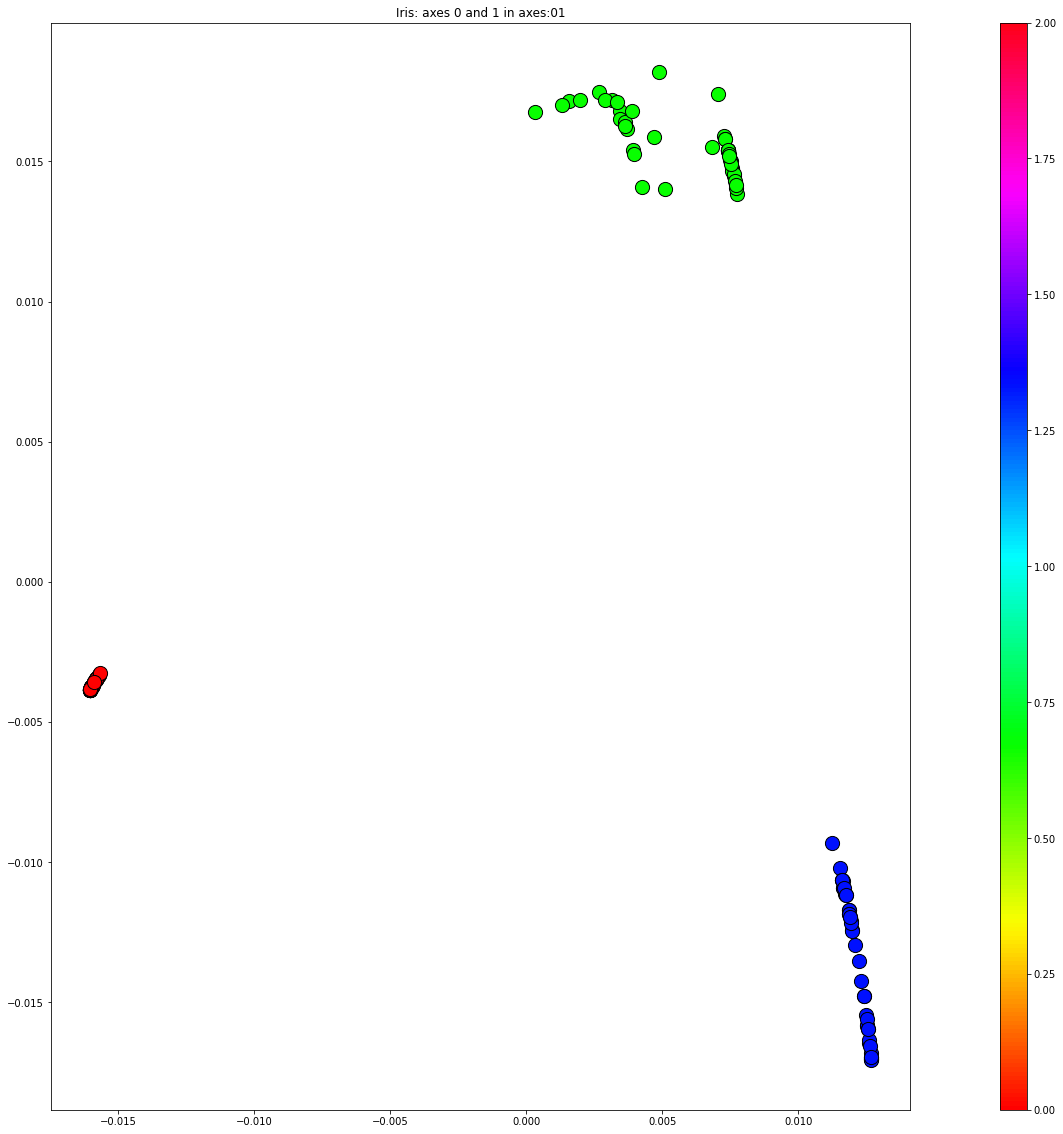

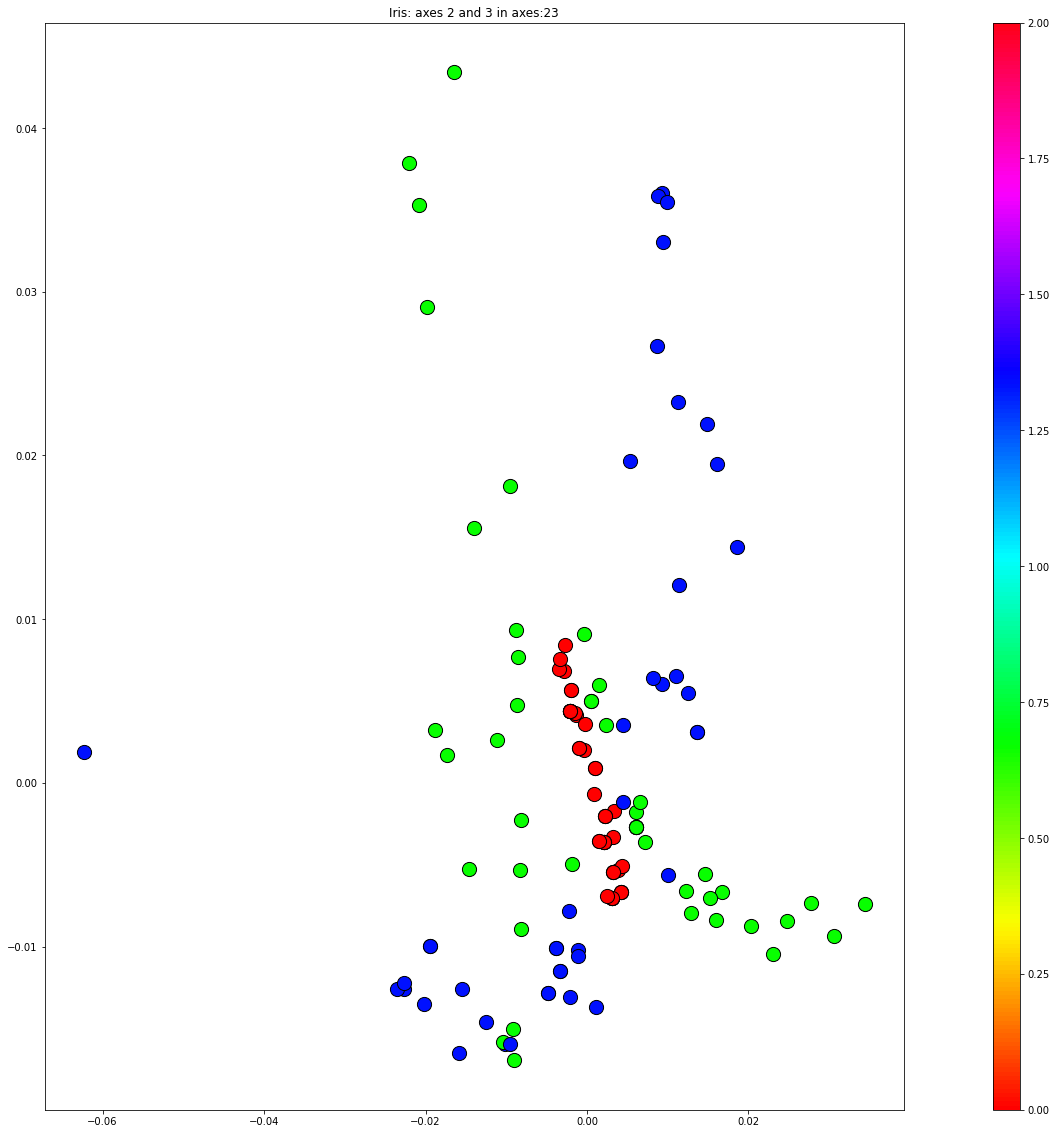

In [9]:
# Selection of dataset. Uncommnet one dataset

dname = "Iris"     # Single label dataset
#dname = "Digit"    # Single label dataset
#dname = "Emotions"     # Multi-label dataset

X_train,Y_train,X_test,Y_test =dataset(dname)

# Execute Supervised Laplacian Eigenmap
la = 0.3 # Recommended (1.0 for no label information)
#la = 0.0
map_d = 4

Z_train,manifolder= SLE(X_train,Y_train,la=la, map_d=map_d)     
# specify the value of la (0.0=Label only, 1.0=Feature only)

print("Transformed training data size (Z_train)",Z_train.shape)
#print("Transformed training data\n",Z_train)
N,D = X_train.shape
if Y_train.ndim > 1:
    Cd = np.sum(Y_train,axis=1)
    print("*Multi labels* N=",N, " Av. label numbers={:5.2f}".format(np.sum(Cd)/N))
if Y_train.ndim > 1 and np.sum(Cd)/N>1:
    multi_label = True
else:
    multi_label = False
    
if multi_label == True:      # Multi-labels
    display_features = [0,1]
    ofile = dname+"_multi_01.png"
    xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train, 
            savefile=ofile, distinct=False,tname=
            dname+": multiple labels (overlapped color)",axes=display_features)
    if map_d > 3:
        display_features = [2,3]
        ofile = dname+"_multi_23.png"
        xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train, 
            savefile=ofile, distinct=False,tname=
            dname+": multiple labels (overlapped color)",axes=display_features)
    
    ofile = dname+"_distinct.png"
    display_features = [0,1]
    xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train,
            savefile=ofile, distinct=True, tname =
            dname+": distinct label sets",axes=display_features)
else:  # Single labels
    display_features = [0,1]

    ofile = dname+"_single_01.png"
    xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train, savefile=ofile, distinct=False, 
                                          tname=dname+": axes 0 and 1",axes=display_features)
    if map_d > 3:
        display_features = [2,3]
        ofile = dname+"_single_23.png"
        xdmin,xdmax,ydmin,ydmax=two_d_display(Z_train,Y_train, savefile=ofile, distinct=False, 
                                          tname=dname+": axes 2 and 3",axes=display_features)
    